# CIFAR 100 - Convolutional Neural Network

Using CIFAR 100 dataset, try to get the best score using a Convolutional Neural Network.
--

Antonio Nogués Podadera

Index: 

1. Importing libraries
2. Loading CIFAR 100 dataset
3. Preprocessing
4. Network Architecture
5. Scores

## 1. Importing the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
import tensorflow as tf
from aux_func import show_history, r2_keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.keras.layers import Dropout

## 2. Load the dataset

In [4]:
from tensorflow.keras.datasets import cifar100

(X_train_cifar100, y_train_cifar100), (X_validation_cifar100, y_validation_cifar100) = cifar100.load_data()
X_train_cifar100 = X_train_cifar100/255
X_validation_cifar100 = X_validation_cifar100/255

169001437/169001437 [==============================] - 2s 0us/step


Número de elementos en el dataset =  60000


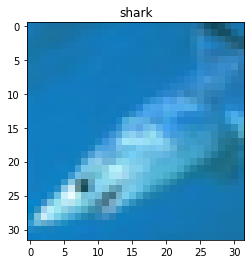

In [5]:
labels = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl',
          'boy', 'bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee',
          'clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish',
          'forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard',
          'lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange',
          'orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum',
          'rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail',
          'snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television',
          'tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm']

print('Número de elementos en el dataset = ',X_train_cifar100.shape[0]+X_validation_cifar100.shape[0])
plt.title(labels[int(y_train_cifar100[50])])
plt.imshow(X_train_cifar100[50])
plt.show()

## 3. Random transformations are applied to images, batch normalization y dropout.

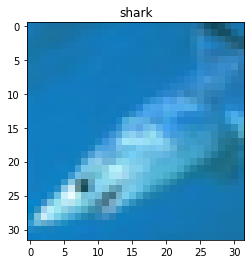

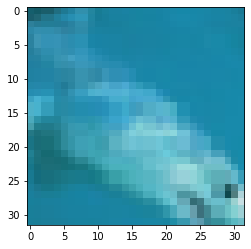

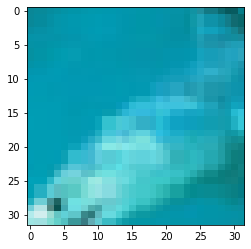

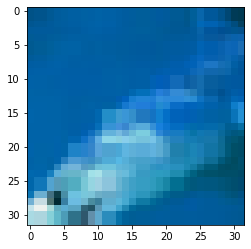

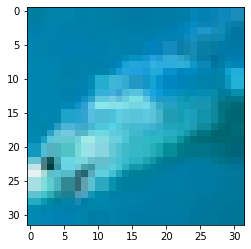

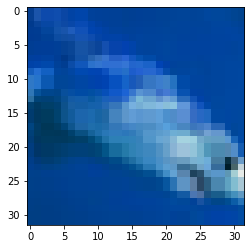

In [9]:
from tensorflow.data import Dataset

# Creamos un Dataset utilizando numpys
train_ds = Dataset.from_tensor_slices((X_train_cifar100, y_train_cifar100))
val_ds = Dataset.from_tensor_slices((X_validation_cifar100, y_validation_cifar100))

# Seleccionamos el batch_size que
batch_size = 50

# Creamos una función que perturbará de forma aleatoria las imágenes. ESTA FUNCION ES LA QUE GENERA EL DATA AUGMENTATION.
# Las etiquetas quedan invariantes
def processing_data(image, label):
    image = tf.image.random_flip_left_right(image)  # Estas son las modificaciones de las imagenes. Aqui la gira de izq a derecha.
    image = tf.image.random_brightness(image, 0.2)  # Le cambia la luminosidad de manera aleatoria
    image = tf.image.random_contrast(image, 0.8, 1.2) # Contraste de la imagen
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.resize(image, (40,40), method='nearest',antialias=False)
    image = tf.image.random_crop(image, (32,32,3))
    return image, label


# Esta función hará las modificaciones pertinentes al dataset para poder usarlo durante el entrenamiento
def data_aug(ds: Dataset, shuffle=False, augment=False):
    # Hacemos que el dataset se repita de manera indefinida. Hacemos que el dataset sea infinito. Cuando tensorflow llega al final, llega al principio y empieza.
    ds = ds.repeat() # Si le pongo dentro del parentesis un 2 es que lo repite dos veces. Si lo dejo vacio es infinito. 

    # Aleatorizamos el dataset usando un buffer de 5000
    if shuffle:
        ds = ds.shuffle(5000) # Aqui remueve los elementos. Aqui hay que poner un numero grande. 

    # Aplicamos las transformaciones pertinentes. # Si le ponemos un true al principio en augment, le aplica estas transformaciones a las imagenes.
    if augment:
        ds = ds.map(processing_data,num_parallel_calls=4) 

    # Hacemos que el dataset este formado por batches
    ds = ds.batch(batch_size) # Batchsize que le hemos definido. 

    # Devolvemos el dataset precargándolo
    return ds.prefetch(buffer_size=4)

# Aplicamos la función data_aug a nuestro dataset. Al train.
train_ds = data_aug(train_ds, shuffle=True, augment=False)
# Al dataset de validación no le aplicamos perturbaciones
val_ds = data_aug(val_ds)


# Visualizemos unos ejemplos de como la función processing_data modifica las imágenes
plt.title(labels[int(y_train_cifar100[50])])
plt.imshow(X_train_cifar100[50])
plt.show()
for _ in range(5):
    image_mod = np.array(processing_data(X_train_cifar100[50], 0)[0])
    plt.imshow(image_mod)
    plt.show()

## 4. Network Architecture

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=200, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dropout(0.7)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=100, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss  wa
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, mode='max')

history = model.fit(train_ds, batch_size=55, epochs=100,
                    steps_per_epoch=1000, validation_data=val_ds, validation_steps=100, callbacks=[reduce_lr])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 50)        1400      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 50)       200       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 100)       45100     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 100)        0   

## 5. Scores

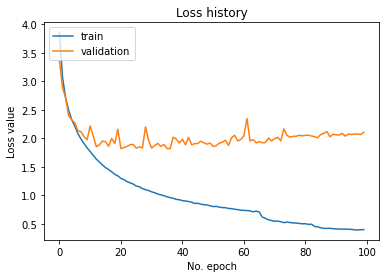

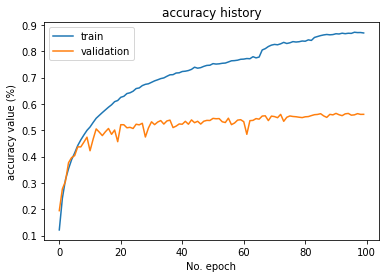

In [12]:
show_history(history)

#### After having made numerous tests, this is the combination of optimizers and architecture that I have obtained the best result with the CIFAR100 dataset, where a val_accuracy of 56.06% is obtained.